In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from IPython.display import Image as display_image
from okiya import draw_tiles

Каждый тайл это квадратная карточка игры. Соответствует значению от 0 до 15.  

In [2]:
tiles = np.array([i for i in range(0,16)]).reshape([4,4])

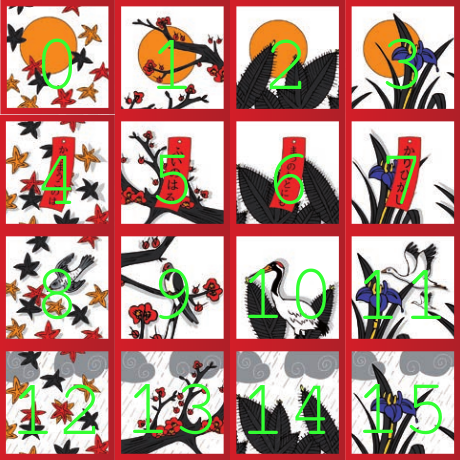

In [3]:
draw_tiles(tiles, draw_numbers = True, hi_res = False)
display_image("images/tiles.png")

Опишем связь тайлов

In [4]:
tiles = np.array([i for i in range(0,16)]).reshape([4,4])
tile_relations = []
for row in range(4):
    for col in range(4):
        relation = tiles[row][col]
        a = tiles[row]
        b = tiles[:,col]
        c = np.concatenate([a,b])
        c = c[np.where(c!=row*4+col)]
        c = np.array(list(set(c)))
        tile_relations.append(c)
#tile_relations = np.array(tile_relations).astype(np.float32)
#str(tile_relations).replace('array([','{').replace('])','}').replace('[','{').replace(']','}')
tile_relations

[array([ 1,  2,  3,  4,  8, 12]),
 array([ 0,  2,  3,  5,  9, 13]),
 array([ 0,  1,  3,  6, 10, 14]),
 array([ 0,  1,  2,  7, 11, 15]),
 array([ 0,  5,  6,  7,  8, 12]),
 array([ 1,  4,  6,  7,  9, 13]),
 array([ 2,  4,  5,  7, 10, 14]),
 array([ 3,  4,  5,  6, 11, 15]),
 array([ 0,  4,  9, 10, 11, 12]),
 array([ 1,  5,  8, 10, 11, 13]),
 array([ 2,  6,  8,  9, 11, 14]),
 array([ 3,  7,  8,  9, 10, 15]),
 array([ 0,  4,  8, 13, 14, 15]),
 array([ 1,  5,  9, 12, 14, 15]),
 array([ 2,  6, 10, 12, 13, 15]),
 array([ 3,  7, 11, 12, 13, 14])]

16 и 17 изображение в массиве, зарезервированы под карточки игроков.

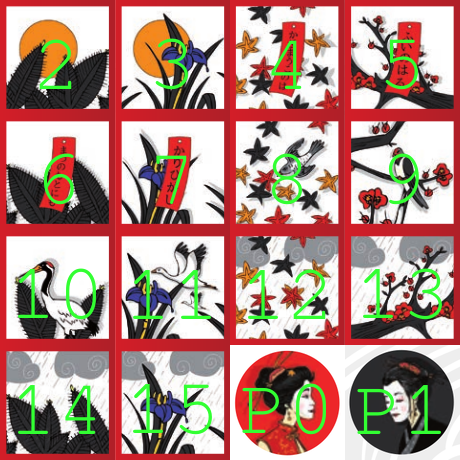

In [5]:
draw_tiles(tiles+2, draw_numbers = True, hi_res = False)
display_image("images/tiles.png")

Установим начальное расположение тайлов игры.  

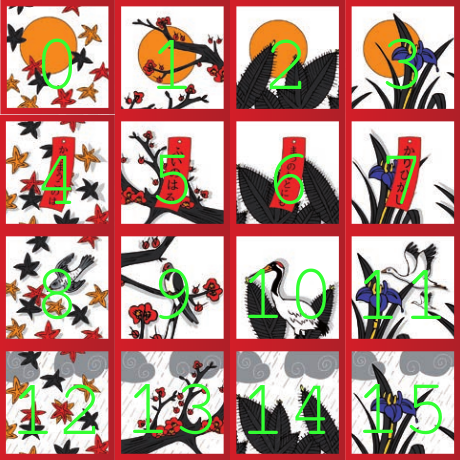

In [6]:
draw_tiles(tiles, draw_numbers = True, hi_res = False)
display_image("images/tiles.png")

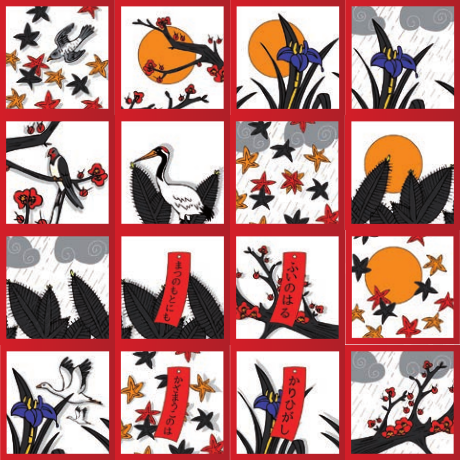

In [7]:
init_tiles = np.array([
    [8,1,3,15],
    [9,10,12,2],
    [14,6,5,0],
    [11,4,7,13]
])
draw_tiles(init_tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

# 16

In [8]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__global__ void last_turn(float *outvec)
{
    int ones = 0;
    int a = 0;
    
    // Идентификатор блока-потока
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    // Убедимся, что число единиц и нулей в комбинации одинаково
    for(a=0;a<16;a++) if ((((int)round(pow(2,a)))&i)>0) ones++;
    
    // Проверим, победна ли комбинация среди возможных
    if (ones==8 && win_combination(i)) outvec[i] = 1;
}
""")

In [9]:
combination_check_gpu = ker.get_function("last_turn")

combinations = np.zeros(256*256).astype(np.float32)
combinations_gpu_out = gpuarray.to_gpu(combinations)

%time combination_check_gpu( combinations_gpu_out, block=(256,1,1), grid=(256,1,1))

CPU times: user 867 µs, sys: 118 µs, total: 985 µs
Wall time: 970 µs


In [10]:
out_combinations = combinations_gpu_out.get()
print('Количество победных комбинаций:', np.count_nonzero(out_combinations))

Количество победных комбинаций: 6315


Посмотрим, на некоторые победные комбинации.

In [11]:
def bin_interpretation(i):
    clear_bin = bin(i)[2:]
    lead_zeros = ''.join(['0' for z in range(16-len(clear_bin))])
    return lead_zeros+clear_bin

In [12]:
win_combinations = np.where(out_combinations == 1)[0]

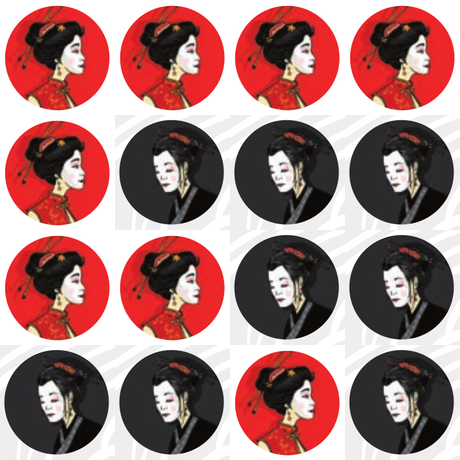

In [13]:
i = 100 # get a 100-th combination, for example
i_bin = bin_interpretation(win_combinations[i])
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

# 15

In [14]:
comb_count = 6315
empty_count = 16
comb_count * empty_count

101040

In [15]:
bin_interpretation(int(6315)), int('1100010101011',2), len('1100010101011')

('0001100010101011', 6315, 13)

In [16]:
bin_interpretation(int(15)), int('1111',2), len('1111')

('0000000000001111', 15, 4)

In [17]:
comb_count_15 = int(''.join([str('1') for i in range(13+4)]),2)
comb_count_15

131071

In [18]:
grid_count = np.ceil(comb_count_15/1024)
grid_count

128.0

In [19]:
print(grid_count, 'Сеток потребуется для охвата', grid_count*1024, 'комбинаций при', 1024, 'блоках')

128.0 Сеток потребуется для охвата 131072.0 комбинаций при 1024 блоках


In [20]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__global__ void turn(float *bias_16, float *weight_16, float *bias_15, float *weight_15)
{   
    // Идентификатор блока-потока
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    //Распаковка идентификаторов
    int comb = i>>(4); // Одна из 8191 комбинаций

    if (comb<6315) // Нас интересуют только 6315 комбинаций
    {
        int cell = i&15; // Ячейка карты, которую будем обнулять
        
        //Вес 15 хода копируется с веса 16 хода
        weight_15[i]=weight_16[comb];
        
        //Заполним смещения 15 хода
        //Погасим одну из ячеек поля, применив побитовое И с одним битом нуля к нашей комбинации
        int zeros[16] = {32767,49151,57343,61439,63487,64511,65023,65279,65407,65471,65503,65519,65527,65531,65533,65534};
        int comb_zero = (int)bias_16[comb]&zeros[cell];
        
        //Если вычитание затронуло фишки игрока 1 
        //и комбинация все еще победна для игрока 1, добавляем вес
        if (comb_zero != (int)bias_16[comb] && win_combination(comb_zero)) weight_15[i] ++;
    }

}
""")

In [21]:
turn_15 = ker.get_function("turn")

bias_16 = np.where(out_combinations == 1)[0].astype(np.float32)
weight_16 = np.ones(6315).astype(np.float32)
weight_15 = np.zeros(6315 * 16).astype(np.float32)
bias_15 = np.zeros(6315 * 16).astype(np.float32)

bias_16_gpu = gpuarray.to_gpu(bias_16)
weight_16_gpu = gpuarray.to_gpu(weight_16)
bias_15_gpu = gpuarray.to_gpu(bias_15)
weight_15_gpu = gpuarray.to_gpu(weight_15)

turn_15(bias_16_gpu,weight_16_gpu,bias_15_gpu,weight_15_gpu,block=(1024,1,1), grid=(int(grid_count),1,1))

In [22]:
weight_15_np = weight_15_gpu.get()
print('Количество победных комбинаций 15-го хода:',np.count_nonzero(weight_15_np-1))

Количество победных комбинаций 15-го хода: 29340


In [23]:
win_combinations = np.where(weight_15_np == 2)[0]

In [24]:
def unzip(full_int):
    part_a = full_int>>(4)
    part_b = full_int&int('1111',2)
    return part_a, part_b

In [25]:
i = 1000 # get a 1000-th combination, for example
comb, cell = unzip(win_combinations[i])
comb, cell

(187, 14)

In [26]:
i_bin = bin_interpretation(int(bias_16[comb]))

In [27]:
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias

In [28]:
# we have 1 game tile at 15-th turn
tiles_16 = tiles.reshape(16)
tiles_16[cell] = init_tiles.reshape(16)[cell]
tiles = tiles_16.reshape([4,4])

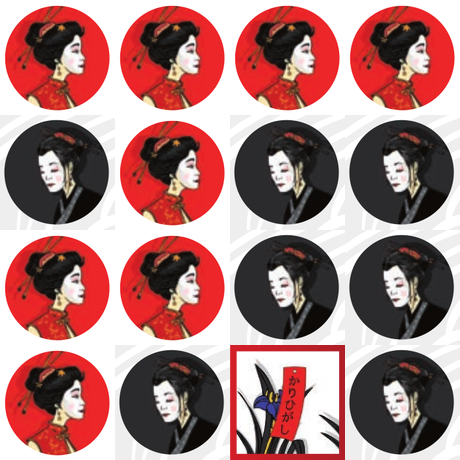

In [29]:
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

# 14

In [30]:
comb_count = 29340
empty_count = 16*16
comb_count_14 = comb_count * empty_count
comb_count_14

7511040

In [31]:
bin_interpretation(comb_count), len('111001010011100'), len('111001010011100')+4+4

('0111001010011100', 15, 23)

In [32]:
int(''.join(['1' for i in range(15)]),2)

32767

In [33]:
comb_count = int(''.join(['1' for i in range(23)]),2)
comb_count

8388607

In [34]:
grid_count = int(np.ceil(comb_count/1024))
grid_count

8192

In [35]:
print(grid_count, 'Сетки потребуется для охвата', grid_count*1024, 'комбинаций при', 1024, 'блоках')

8192 Сетки потребуется для охвата 8388608 комбинаций при 1024 блоках


In [36]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__global__ void turn(float *bias_15, float *weight_15, float *bias_14, float *weight_14)
{   
    // Нулевые ячейки
    int zeros[16] = {32767,49151,57343,61439,63487,64511,65023,65279,65407,65471,65503,65519,65527,65531,65533,65534};
    
    // Связи ячеек
    int relations[16][6] = {
    { 1,  2,  3,  4,  8, 12}, 
    { 0,  2,  3,  5,  9, 13}, 
    { 0,  1,  3,  6, 10, 14}, 
    { 0,  1,  2,  7, 11, 15}, 
    { 0,  5,  6,  7,  8, 12}, 
    { 1,  4,  6,  7,  9, 13}, 
    { 2,  4,  5,  7, 10, 14}, 
    { 3,  4,  5,  6, 11, 15}, 
    { 0,  4,  9, 10, 11, 12}, 
    { 1,  5,  8, 10, 11, 13}, 
    { 2,  6,  8,  9, 11, 14}, 
    { 3,  7,  8,  9, 10, 15}, 
    { 0,  4,  8, 13, 14, 15}, 
    { 1,  5,  9, 12, 14, 15}, 
    { 2,  6, 10, 12, 13, 15}, 
    { 3,  7, 11, 12, 13, 14}
    };
    
    // Идентификатор блока-потока
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    //Распаковка идентификаторов
    // >111001010011100< [1111] [1111]
    int comb = i>>(4+4); // Одна из 32767 комбинаций

    if (comb<29340) // Нас интересуют только 29340 комбинаций
    {
        // Идентификатор 0-й ячейки карты, которую будем обнулять
        // [111001010011100] [1111] >1111<
        int cell_0 = i&15; 
        
        // Идентификатор 1-й ячейки карты, которую будем обнулять
        // [111001010011100] >1111< [1111]
        int cell_1 = i>>(4)&15;
        
        /*int relation_count = 0;
        int row,col,rel_0,rel_1;
        for (row=0;row<16;row++)
        {
            rel_0 = 0;
            rel_1 = 0;
            for (col=0;col<6;col++)
            {
                if (relations[row][col]==cell_0) rel_0++;
                if (relations[row][col]==cell_1) rel_1++;
                if (rel_0>0&&rel_1>0) relation_count++;
            }
        }*/
        bool related = false;
        for (int col=0;col<6;col++)
        {
            if (relations[cell_0][col]==cell_1) related = true;
        }
        
        if (related && cell_0 != cell_1)
        {
            //Вес 14 хода копируется с веса 15 хода
            weight_14[i]=weight_15[comb];

            //Заполним смещения 15 хода
            //Погасим две ячейки поля, применив побитовое И с одним битом нуля к нашей комбинации
            int comb_zero = (int)bias_15[comb]&zeros[cell_0]&zeros[cell_1];
            //comb_zero = comb_zero&zeros[cell_1];

            //Если вычитание затронуло фишки игрока 1 
            //и комбинация все еще победна для игрока 1, добавляем вес
            if (comb_zero != (int)bias_15[comb] && win_combination(comb_zero)) weight_14[i] ++;
        }
    }

}
""")

In [37]:
turn_14 = ker.get_function("turn")

bias_15 = np.where(weight_15_np == 2)[0].astype(np.float32)
weight_15 = np.ones(29340).astype(np.float32)+1
weight_14 = np.zeros(8388607).astype(np.float32)
bias_14 = np.zeros(8388607).astype(np.float32)

bias_15_gpu = gpuarray.to_gpu(bias_15)
weight_15_gpu = gpuarray.to_gpu(weight_15)
bias_14_gpu = gpuarray.to_gpu(bias_14)
weight_14_gpu = gpuarray.to_gpu(weight_14)
#tile_relations_gpu = gpuarray.to_gpu(tile_relations)

turn_14(
    bias_15_gpu,
    weight_15_gpu,
    bias_14_gpu,
    weight_14_gpu,
    #tile_relations_gpu,
    block=(1024,1,1),
    grid=(int(grid_count),1,1)
)

In [38]:
weight_14_np = weight_14_gpu.get()
np.where(weight_14_np == 3)[0]

array([   3643,    3707,    3723, ..., 7508987, 7508989, 7508990])

In [39]:
win_combinations = np.where(weight_14_np == 3)[0]
print('Количество победных комбинаций 14-го хода:',len(win_combinations))

Количество победных комбинаций 14-го хода: 814200


In [40]:
def unzip(full_int, cell_count):
    part_a = full_int>>(4*cell_count)
    part_b = full_int>>(4*cell_count-1)&int('1111',2)
    part_c = full_int&int('1111',2)
    return part_a, part_b, part_c

In [41]:
i = 10000 # get a 10 000-th combination, for example
comb, cell_0, cell_1  = unzip(win_combinations[i], 2)
comb, cell_0, cell_1

(963, 6, 3)

In [42]:
i_bin = bin_interpretation(int(bias_16[comb]))
i_bin

'0010010100111011'

In [43]:
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias
tiles

array([[16, 16, 17, 16],
       [16, 17, 16, 17],
       [16, 16, 17, 17],
       [17, 16, 17, 17]])

In [44]:
# we have 2 game tile at 15-th turn
tiles_16 = tiles.reshape(16)
tiles_16[cell_0] = init_tiles.reshape(16)[cell_0]
tiles_16[cell_1] = init_tiles.reshape(16)[cell_1]
tiles = tiles_16.reshape([4,4])
tiles

array([[16, 16, 17, 15],
       [16, 17, 12, 17],
       [16, 16, 17, 17],
       [17, 16, 17, 17]])

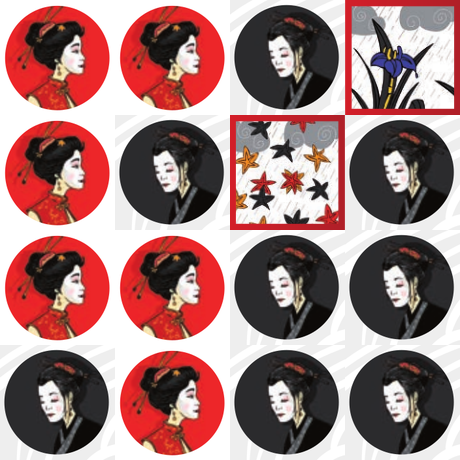

In [45]:
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

# 13

In [46]:
comb_count = len(win_combinations)
empty_count = 16*16*16
comb_count_13 = comb_count * empty_count
comb_count, comb_count_13

(814200, 3334963200)